# HT-MEK Data Processing Workbook
Author: Micah Olivas

In [35]:
# This will autoreload imported modules
%load_ext autoreload
%autoreload 2

# Import modules
from experiment_processing import processing

# Set up parallel processing
processing.pandarallel.initialize(progress_bar=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Import kinetic and standard series data

Read raw kinetic and standards data with Pandas

In [18]:
kinetic_data_path = '/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/230207/230207_SFL_nanobody/Assays/AcP_titration/d2_TitrationSeries_Analysis.csv.bz2'
standard_data_path = '/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/230207/230207_SFL_nanobody/Standards/Analysis/d2_pbp_StandardSeries_Analysis.csv.bz2'
egfp_data_path = '/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/230207/230207_SFL_nanobody/eGFP/20230208_173620_d2_quant_PBS_pH7_4_egfp/egfp/StitchedImagesGFP_Summary.csv.bz2'
egfp_button_summary_image_path = '/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/230207/230207_SFL_nanobody/eGFP/20230208_173620_d2_quant_PBS_pH7_4_egfp/egfp/StitchedImages/SummaryImages_true/Summary_BGSubtracted_StitchedImg_500_egfp_0.tif'

# experiment information
experimental_day = '230207'
experiment_name = 'Acyp_SFL'
setup = 'S7'
device = 'd2'
egfp_slope = 188847
substrate = 'AcP'
all_substrate_concs = [100, 75, 50, 25, 10]
device_columns = 32
device_rows = 56

# export information
export_path_root = "/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/230207/Interpretation"

# Create dataframes for kinetic and standard series
kinetic_data = processing.pd.read_csv(kinetic_data_path)
standard_data = processing.pd.read_csv(standard_data_path)
egfp_data = processing.pd.read_csv(egfp_data_path)
standard_data = standard_data.dropna()

# Format all dataframes
standard_data, kinetic_data = processing.format_data(standard_data, kinetic_data, substrate, egfp_data)

## Format library member name text

In [19]:
kinetic_data['MutantID'] = kinetic_data['id'].str.replace('human_ACYP2', 'hsapiens2')
standard_data['MutantID'] = standard_data['id'].str.replace('human_ACYP2', 'hsapiens2')

## "Squeeze" DataFrames

At this point, our DataFrames are in a long format: each row of kinetic_data corresponds to an individual timepoint in the kinetic assays, while each row of standard_data corresponds to an individual standard concentration. To support vectorized curve fitting operations later, we want to flatten or "squeeze" rows of each DataFrame into series (e.g. time, intensity, standard concentration) by chamber.

In [36]:
squeeze_kinetics = processing.squeeze_kinetics(kinetic_data)

,x,y,Indices,MutantID,substrate,substrate_conc_uM,summed_button_BGsub_Button_Quant,time_s,kinetic_median_intensities
0,1,1,"01,01",1C8_phorikoshii_pross_2,AcP,10,131388,"[0, 75, 150, 225, 301, 377, 456, 533, 609, 687...","[5780, 5814, 5840, 5874, 5885, 5943, 5950, 597..."
1,1,1,"01,01",1C8_phorikoshii_pross_2,AcP,25,131388,"[0, 75, 150, 227, 304, 381, 458, 536, 613, 690...","[8159, 8244, 8335, 8398, 8468, 8546, 8627, 868..."


"Squeeze" standard data to serialize standard concetrations. Plot representative standard curves

,x,y,Indices,substrate,standard_concentration_uM,standard_median_intensities
0,1,1,"01,01",AcP,"[0, 1, 3, 6, 15, 30, 75, 150]","[4475, 5019, 8899, 8235, 12948, 16133, 16120, ..."
1,1,2,"01,02",AcP,"[0, 1, 3, 6, 15, 30, 75, 150]","[4318, 4855, 8611, 7973, 12537, 15646, 15634, ..."
2,1,3,"01,03",AcP,"[0, 1, 3, 6, 15, 30, 75, 150]","[4367, 4898, 8688, 8037, 12666, 15777, 15749, ..."
3,1,4,"01,04",AcP,"[0, 1, 3, 6, 15, 30, 75, 150]","[4214, 4728, 8370, 7761, 12225, 15217, 15182, ..."


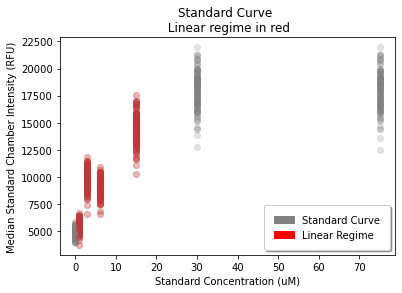

In [37]:
squeeze_standards = processing.squeeze_standard(standard_data)

## Calculate enzyme concentration from eGFP fluorescence

In [38]:
squeeze_kinetics['EnzymeConc'] = squeeze_kinetics['summed_button_BGsub_Button_Quant']/egfp_slope

## Fit PBP Standard Curves

To fit the PBP standard curve, we need to optimize a nonlinear least squares fit based on the following single-site binding isotherm for the phosphate sensor:

$I([Pi]) = 0.5A(KD +[Pi]+[PS]-\sqrt{(KD +[PS]+[Pi])^2 - 4[PS][Pi]}) + I(0μM)$

where $I([Pi])$ is the median fluorescence at a given $[Pi]$, $[PS]$ is the concentration of PBP, $K_D$ is the dissociation constant of Pi from PBP, $A$ is the scaling factor necessary to relate fraction PBP bound to observed fluorescence, and $I(0μM[Pi])$ is the median fluorescence intensity of PBP in the absence of added Pi.

To find product concentrations from measured intensities, we need to invert this isotherm. For this, we use the package `sympy`, which has a nice suite of tools for symbolic math.

In [8]:
A, KD, P_i, PS, I_0uMP_i, I_P_i = symbols('A KD P_i PS I_0uMP_i I_P_i')

isotherm_inverse = solve(0.5 * A * (KD + P_i + PS - ((KD + PS + P_i)**2 - 4*PS*P_i)**(1/2)) + I_0uMP_i - I_P_i, P_i)
print('Inverse of isotherm:', isotherm_inverse)

Inverse of isotherm: [(-A*I_0uMP_i*KD - A*I_0uMP_i*PS + A*I_P_i*KD + A*I_P_i*PS - I_0uMP_i**2 + 2.0*I_0uMP_i*I_P_i - I_P_i**2)/(A*(A*PS + I_0uMP_i - I_P_i))]


If we would like to fit the inverse, we can simply copy this function into the following cell to perform the nonlinear least squares fit. Instead, we will densely interpolate the curve fits for each chamber and use the interpolations to approximate `[Pi]` concentration. The following function optimizes a least squares fit for each standard curve in each chamber and stores the optimum paramters as a list [`A, KD, PS, I_0uMP_i`] in the column `standard_popt`.

Now, let's check a few of the curve fits to make sure they look appropriate

Performing curve fits...


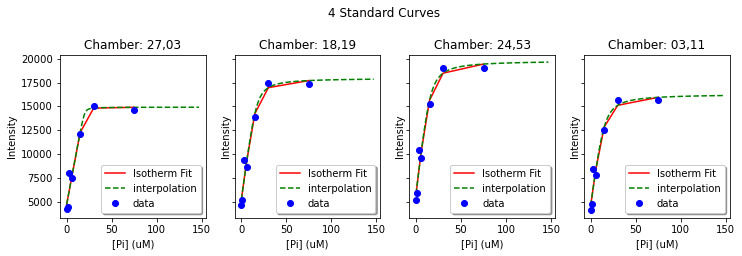

In [41]:
squeeze_standards = processing.standard_curve_fit(squeeze_standards)

## Merge dataframes

Next we merge the standard and kinetic data on the chamber Indices and substrate columns and convert the kinetic median intensities to product concentrations using the standard curve slope. To convert median assay intensities to product concentrations, we interpolate the curve fit and generate a lookup dictionary. This method should be replaced with a rigorous interpolation, but it will do for now.

In [47]:
sq_merged = processing.merge_and_get_product_concs(squeeze_kinetics, squeeze_standards) 
sq_merged.head(1)

Calculating product concentrations...
If interpolating, this may take longer than the curve fitting...


,x,y,Indices,MutantID,substrate,substrate_conc_uM,summed_button_BGsub_Button_Quant,time_s,kinetic_median_intensities,EnzymeConc,standard_concentration_uM,standard_median_intensities,standard_popt,kinetic_product_concentration_uM
0,1,1,"01,01",1C8_phorikoshii_pross_2,AcP,10,131388,"[0, 75, 150, 225, 301, 377, 456, 533, 609, 687...","[5780, 5814, 5840, 5874, 5885, 5943, 5950, 597...",0.695738,"[0, 1, 3, 6, 15, 30, 75, 150]","[4475, 5019, 8899, 8235, 12948, 16133, 16120, ...","[828.1181524329919, 2.0953878051518657, 14.423...","[1.2, 1.275, 1.275, 1.3499999999999999, 1.3499..."


# Manual eGFP Flagging (only for [E] above the background)

In [12]:
# get expression values from all chambers
all_chambers_expression = sq_merged[[ "Indices", 'MutantID', 'EnzymeConc']].drop_duplicates(subset=['Indices'], keep='first')

# get Indices from all chambers
concs_Indices = all_chambers_expression.loc[all_chambers_expression.EnzymeConc > 0][['EnzymeConc','Indices']].sort_values('EnzymeConc', ascending = False).to_numpy().tolist()
Indices_to_visualize = [(enzyme_conc, tuple([int(i) for i in i.split(',')])) for enzyme_conc, i in concs_Indices]

# indicate whether a previous culling record exists and if so include the filepath
culling_record_exists = True
culling_record_filepath = '/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/230207/Interpretation/manual_culling.csv'

#### Read the image, slice it

In [13]:
NUM_ROWS = 56
NUM_COLS = 32

# create button array
button_img_arr = np.asarray(Image.open(egfp_button_summary_image_path))
height, width = button_img_arr.shape

# define stamp dimensions
stamp_height = int(height/NUM_ROWS)
stamp_width = int(width/NUM_COLS)

button_stamps = {}
for row in range(NUM_ROWS):
    for col in range(NUM_COLS):
        button_stamps[(col+1, row+1)] = button_img_arr[row*stamp_height:row*stamp_height+stamp_height, col*stamp_width:col*stamp_width+stamp_width]

button_stamps_subset = [(enzymeconc, key, button_stamps[key]) for enzymeconc, key in Indices_to_visualize]

In [14]:
def create_expanded_button(description, button_style):
    return Button(description=description, button_style=button_style, layout=Layout(height='200px', width='200px'))


def capture_button(chamberindex):
    def on_button_clicked(b):
        global flagged_set
        if b['new'] == True:
            flagged_set.add(chamberindex)
            b['new'] = False
        else:
            b['new'] = True
            flagged_set.remove(chamberindex)
    return on_button_clicked


def create_toggle_button(label):
    return widgets.ToggleButton(
    value=False,
    description=label,
    disabled=False,
    layout=widgets.Layout(height='25px', width='120px', min_width='30px'),
    button_style='',
    tooltip='label',
    style={'font_weight': 'bold'}, 
    icon='')


def imagearray_to_bytearr(img_arr, format = 'png'):
    """
    The minimum and maximum values np.interp

    """
    rescaled_image = np.interp(x = img_arr, 
                               xp = (img_arr.min(), img_arr.max()), 
                               fp = (0, 10**6.5)
                               ).astype(np.uint32)
    img_byte_buffer = io.BytesIO()
    pil_img = Image.fromarray(rescaled_image)
    pil_img.save(img_byte_buffer, format = format)
    img_byte_arr = img_byte_buffer.getvalue()
    return img_byte_arr


def make_image_pane(imagearr):
    return widgets.Image(
            value= imagearray_to_bytearr(imagearr),
            format='png',
            width='80px', height='80px', 
            min_width='80px', 
            max_height = '80px', max_width = '80px')


def make_button_grid():
    items1 = []
    for enzymeconc, indices, imagearr in button_stamps_subset:
        
        chamber_index = str(indices)+' '+str(round(enzymeconc, 1))+' nM'
        tb = create_toggle_button(chamber_index)
        
        record_index_name = str(indices[0])+','+str(indices[1])
        tb.observe(capture_button(record_index_name), 'value')
        hb = widgets.VBox([tb, make_image_pane(imagearr), widgets.Label('.\n.')], 
                          width='120px', 
                          height = '220px',
                          min_height='220px',
                          min_width='120px',
                          overflow_x = 'none')
        hb.layout.align_items = 'center'
        hb.layout.object_fit = 'contain'
        hb.layout.object_position = 'top center'
        items1.append(hb)

    box_layout = widgets.Layout(overflow='scroll',
                    border='3px solid black',
                    width='1200px',
                    height='600px',
                    flex_flow='row wrap',
                    min_width='200px',
                    display='flex')
    scrollbox = widgets.Box(items1, layout = box_layout)
    return scrollbox


if culling_record_exists == True:
    df = pd.read_csv(culling_record_filepath)
    flagged_set = set(df.loc[df['egfp_manual_flag'] == True]['Indices'])

    for i in flagged_set:
        capture_button(i)
else:
    flagged_set = set()

### Select bad chambers

In [132]:
bg = make_button_grid()
display(bg)

Box(children=(VBox(children=(ToggleButton(value=False, description='(32, 39) 148.2 nM', layout=Layout(height='…

Close button finder and add culling flag to merged DataFrame

In [15]:
# bg.close()

# # overwrite flagged_set if other record exists
# if culling_record_exists == True:
#     df = pd.read_csv(culling_record_filepath)
#     flagged_set = set(df.loc[df['egfp_manual_flag'] == True]['Indices'])

print('Flagged {} chamber(s)'.format(len(flagged_set)))

# add chamber flags to main df
sq_merged['egfp_manual_flag'] = sq_merged.Indices.apply(lambda i: i in flagged_set)

Flagged 88 chamber(s)


### Export the manual culling results

In [153]:
export_path = '/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/230207/Interpretation/manual_culling.csv'

sq_merged.sort_values(['x', 'y',  'MutantID', 'substrate_conc_uM', 'egfp_manual_flag']).to_csv(export_path)

# Calculate initial rates
To calculate initial rates for each substrate condition, we apply an algorithm adapted from page 27 of the SI in Markin, Mokhtari et al. 2020

**Note**: Maybe we move this to a function defined above.

In [167]:
# first define the pbp_concentration
pbp_conc = 30 # uM

# define the least-squares algorithm
def fit_initial_rates(row, pbp_conc=pbp_conc):

    substrate_conc = row.substrate_conc_uM
    x, y = row.time_s, row.kinetic_product_concentration_uM
    full_x, full_y = x, y 
    first_third = int(len(x)*0.3)
    regime = 0

    if substrate_conc < pbp_conc: # "regime 1"
        regime = 1
        if y[1] >= 0.3*substrate_conc: # fit two points, flag as a two point fit
            x = x[1:3]
            y = y[1:3]
        else: # fit first 30% of the series
            x = x[1:first_third]
            y = y[1:first_third]

    # "regime 2": 30% of the substrate concentration is greater than 2/3 the concentration of PBP.
    elif 0.3*substrate_conc > (2/3)*pbp_conc: # regime "2"
        regime = 2
        x = x[1:first_third]
        y = y[1:first_third]

    # "regime 3": 30% of the substrate concentration is below 2/3 the concentration of PBP. 
    elif 0.3*substrate_conc < (2/3)*pbp_conc: # regime "3"
        regime = 3
        x = x[1:first_third]
        y = y[1:first_third]
        # y = [ i for i in y if i < 0.3 * substrate_conc ] # fit points only if less than 30% of substrate conc
        # x = x[:len(y)]

    # reshape the arrays for least-squares regression
    x = np.array(x)
    y = np.array(y)

    # perform fit
    m, c = np.linalg.lstsq(np.vstack([x, np.ones(len(x))]).T, y, rcond=None)[0] # stores initial rate and intercept, the first two objects in the array

    # set two point flag
    if len(x) == 2:
        two_point = True
    else:
        two_point = False
        
    return m, c, two_point, regime

# next, store the slope in a new column
results = sq_merged.apply(fit_initial_rates, axis=1)

# now add the rates and intercepts to the dataframe
sq_merged['initial_rate'] = results.apply(lambda x: x[0])
sq_merged['initial_rate_intercept'] = results.apply(lambda x: x[1])
sq_merged['two_point_fit'] = results.apply(lambda x: x[2])
sq_merged['rate_fit_regime'] = results.apply(lambda x: x[3])

# sq_merged[['Indices', 'initial_rate']].head(10).round(8)

### Visualize progress curves

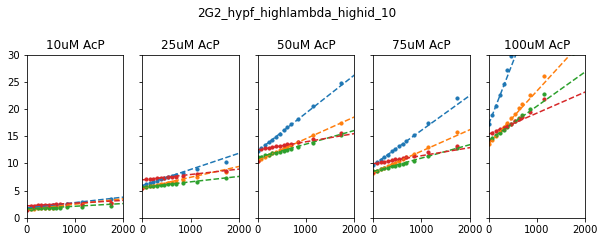

In [231]:
# set list of substrate concentrations
concs = sorted(list(set(sq_merged['substrate_conc_uM'])))
conc_d = dict(zip(range(len(concs)), concs))

# sample a random mutants and subset the progress curve dictionary
check = np.random.choice(list(set(sq_merged['MutantID'])), 1)[0]
my_df = sq_merged[sq_merged['MutantID'] == check]
my_df

fig, axs = plt.subplots(ncols=5, figsize=(10, 3), sharey=True)

for k,v in conc_d.items():
    v_df = my_df[my_df['substrate_conc_uM'] == v]

    for index, row in v_df.iterrows():
        times, product_concs = row['time_s'], row['kinetic_product_concentration_uM']
        m, b = row.initial_rate, row.initial_rate_intercept
        indices = row.Indices

        axs[k].scatter(times, product_concs, s=10)
        axs[k].plot([0, max(times)], [b, m*max(times)+b], '--')
        axs[k].set_title(str(v) + 'uM AcP')
        axs[k].set_xlim(0, 2000)
        axs[k].set_ylim(0, pbp_conc)
        axs[k].set_ylim(0, pbp_conc)

fig.suptitle(check, y=1.1)
plt.show()

# Michaelis-Menten curve fitting

To perform the fitting, we apply another "squeeze" to create columns for the substrate concentration series and initial rate series. Scale initial rates by enzyme concentration

In [232]:
# first, group by Indices to create initial rate and substrate conc series
initial_rates = sq_merged.groupby(['x', 'y', 'Indices', 'MutantID', 'substrate', 'EnzymeConc', 'egfp_manual_flag'])['initial_rate'].apply(list).reset_index(name='initial_rates')
substrate_concs = sq_merged.groupby(['x', 'y', 'Indices', 'MutantID', 'substrate', 'EnzymeConc', 'egfp_manual_flag'])['substrate_conc_uM'].apply(list).reset_index(name='substrate_concs')
squeeze_mm = pd.merge(substrate_concs, initial_rates, on=['x', 'y', 'Indices', 'MutantID', 'substrate', 'EnzymeConc', 'egfp_manual_flag'])

squeeze_mm['substrate_concs'] = squeeze_mm['substrate_concs'].apply(lambda x: [0] + x) # insert zero at beginning of list
squeeze_mm['initial_rates'] = squeeze_mm['initial_rates'].apply(lambda x: [0] + x) # insert zero at beginning of list

# now, save substrate concs
all_substrate_concs = squeeze_mm['substrate_concs'][0]

squeeze_mm

,x,y,Indices,MutantID,substrate,EnzymeConc,egfp_manual_flag,substrate_concs,initial_rates
0,1,1,"01,01",1C8_phorikoshii_pross_2,AcP,0.695738,False,"[0, 10, 25, 50, 75, 100]","[0, 0.0004999999999999972, 0.00197357031565584..."
1,1,2,"01,02",BLANK,AcP,0.748659,False,"[0, 10, 25, 50, 75, 100]","[0, 0.0005000000000000003, 0.00197357031565585..."
2,1,3,"01,03",2A4_sbenthica_lowlambda_highid_7,AcP,79.585802,False,"[0, 10, 25, 50, 75, 100]","[0, 0.0009999999999999944, 0.00345158404985865..."
3,1,4,"01,04",BLANK,AcP,0.578781,False,"[0, 10, 25, 50, 75, 100]","[0, 0.0004999999999999988, 0.00197357031565585..."
4,1,5,"01,05",1G1_phorikoshii_lowlambda_lowid_8,AcP,0.380769,False,"[0, 10, 25, 50, 75, 100]","[0, 0.0005000000000000003, 0.00148234173928098..."
...,...,...,...,...,...,...,...,...,...
1787,32,52,"32,52",BLANK,AcP,7.082342,False,"[0, 10, 25, 50, 75, 100]","[0, 0.0009999999999999976, 0.00148234173928099..."
1788,32,53,"32,53",3A8_WP_090938430.1_1222894983_acylphosphatase_...,AcP,90.972671,False,"[0, 10, 25, 50, 75, 100]","[0, 0.0004999999999999972, 0.00246912689710891..."
1789,32,54,"32,54",BLANK,AcP,0.026609,False,"[0, 10, 25, 50, 75, 100]","[0, 0.0009999999999999976, 0.00345591205493683..."
1790,32,55,"32,55",3A10_AEX04981.1_365909528_acylphosphatase_Kleb...,AcP,137.232580,False,"[0, 10, 25, 50, 75, 100]","[0, 0.003999999999999992, 0.013814992209590897..."


Next, exclude substrate concentrations if necessary

In [233]:
exclude_concs = [50, 75, 100]
# exclude_concs = []

Finally, store the optimal fit parameters in the Michaelis-Menten DataFrame

In [236]:
# define michaelis menten equation
def mm_func(S, Km, Vmax): 
    return Vmax*S/(Km+S)
vfunc = np.vectorize(mm_func)

# define curve fit function
def fit_mm_curve(df, exclude_concs=exclude_concs):

    # store data
    xdata = df.substrate_concs
    ydata = df.initial_rates
    enzyme_conc = df.EnzymeConc
    name = df.MutantID

    # now, exclude substrate concentrations from fit if needed
    for conc in exclude_concs:
        if conc in xdata:
            conc_index = xdata.index(conc)

            del xdata[conc_index]
            del ydata[conc_index]

    ydata_final = ydata
    xdata_final = xdata
    
    # # IN DEVELOPMENT: remove non-approximately increasing rates
    # final_index = 0
    # for index, rate in enumerate(ydata):
    #     if index > 0:
    #         if ydata[index] > (ydata[index-1] * 0.8) :
    #             # trunc_ydata = ydata[:index+1]
    #             final_index += 1
    #         else:
    #             final_index += 0

    # xdata_final = xdata[:final_index]
    # ydata_final = ydata[:final_index]

    # if '1A1_' in name:
    #     xdata_final = xdata[:3]
    #     ydata_final = ydata[:3]
        

    # perform curve fit
    mm_params, pcov = optimize.curve_fit(mm_func, xdata=xdata_final, ydata=ydata_final, bounds=([0, 0], [np.inf, np.inf]))

    # store variables
    KM_fit = mm_params[0] # at this point, this is in uM
    vmax_fit = mm_params[1] # at this point, in uM per second
    kcat_fit = vmax_fit/(enzyme_conc/1000) # at this point, enzyme conc is in nM, so convert to uM; kcat is in s^-1
    kcat_over_KM_fit = 10**6 * kcat_fit/KM_fit # at this point, kcat in s^-1 and KM in uM, so multiply by 1000000 to give s^-1 * M^-1 

    return KM_fit, vmax_fit, kcat_fit, kcat_over_KM_fit, xdata_final, ydata_final

# apply function and store fit parameters
results = squeeze_mm.parallel_apply(fit_mm_curve, axis=1)

squeeze_mm['KM_fit'] = results.apply(lambda x: x[0])
squeeze_mm['vmax_fit'] = results.apply(lambda x: x[1])
squeeze_mm['kcat_fit'] = results.apply(lambda x: x[2])
squeeze_mm['kcat_over_KM_fit'] = results.apply(lambda x: x[3])
squeeze_mm['substrate_concs'] = results.apply(lambda x: x[4])
squeeze_mm['initial_rates'] = results.apply(lambda x: x[5])

/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_95708/3093472957.py:50: RuntimeWarning: divide by zero encountered in double_scalars
  kcat_fit = vmax_fit/(enzyme_conc/1000) # at this point, enzyme conc is in nM, so convert to uM; kcat is in s^-1
/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_95708/3093472957.py:50: RuntimeWarning: divide by zero encountered in double_scalars
  kcat_fit = vmax_fit/(enzyme_conc/1000) # at this point, enzyme conc is in nM, so convert to uM; kcat is in s^-1


In [237]:
squeeze_mm[squeeze_mm['MutantID'].str.contains('1A1')]

,x,y,Indices,MutantID,substrate,EnzymeConc,egfp_manual_flag,substrate_concs,initial_rates,KM_fit,vmax_fit,kcat_fit,kcat_over_KM_fit
72,2,17,"02,17",1A11_hsapiens2_highlambda_highid_3,AcP,45.319179,False,"[0, 10, 25]","[0, 0.02100000000000001, 0.08199999999999998]",11576.157411,36.153772,797.758759,68913.952268
110,2,55,"02,55",1A1_hsapiens2_wt,AcP,121.150730,False,"[0, 10, 25]","[0, 0.011999999999999983, 0.045999999999999985]",8733.199778,15.336274,126.588378,14495.074124
118,3,7,"03,07",1A10_hsapiens2_highlambda_highid_2,AcP,81.312247,False,"[0, 10, 25]","[0, 0.022999999999999975, 0.23699999999999996]",34753.971636,295.220847,3630.705782,104468.801999
166,3,55,"03,55",1A1_hsapiens2_wt,AcP,113.229344,False,"[0, 10, 25]","[0, 0.01599999999999998, 0.12499999999999993]",23189.447867,105.166386,928.790912,40052.308159
222,4,55,"04,55",1A1_hsapiens2_wt,AcP,121.542688,False,"[0, 10, 25]","[0, 0.015000000000000008, 0.1999999999999999]",23169.398609,164.726948,1355.301178,58495.311044
278,5,55,"05,55",1A1_hsapiens2_wt,AcP,115.478573,False,"[0, 10, 25]","[0, 0.014999999999999975, 0.12799999999999992]",23189.884602,107.248887,928.734090,40049.103558
324,6,45,"06,45",1A10_hsapiens2_highlambda_highid_2,AcP,96.782035,False,"[0, 10, 25]","[0, 0.014999999999999975, 0.11499999999999999]",23189.241032,96.841940,1000.618963,43150.138545
768,14,41,"14,41",1A10_hsapiens2_highlambda_highid_2,AcP,108.538229,False,"[0, 10, 25]","[0, 0.016999999999999973, 0.21500000000000002]",23169.306793,177.360924,1634.087135,70528.097795
990,18,39,"18,39",1A12_hsapiens2_highlambda_highid_4,AcP,96.150529,False,"[0, 10, 25]","[0, 0.016000000000000014, 0.06999999999999999]",11579.485504,30.562927,317.865403,27450.736256
1310,24,23,"24,23",1A12_hsapiens2_highlambda_highid_4,AcP,98.239474,False,"[0, 10, 25]","[0, 0.01899999999999999, 0.09900000000000003]",17395.561926,64.021363,651.686743,37462.816429


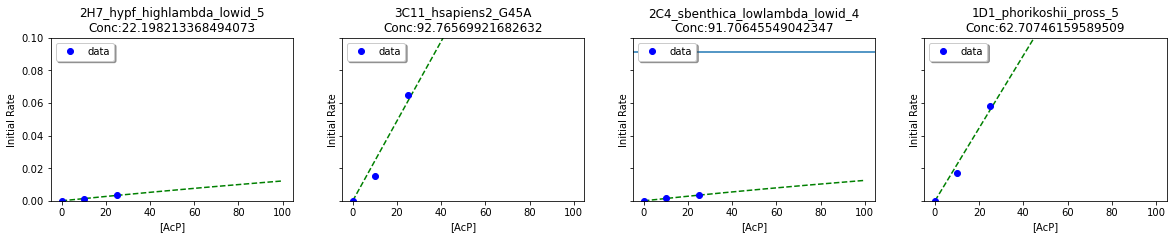

In [238]:
# ==========================================================================================

# select example chambers to plot
num_examples = 4
examples_df = squeeze_mm[squeeze_mm['MutantID'] != 'BLANK'].sample(num_examples)
examples_df = examples_df.reset_index()

# plot subplots
fig, axs = plt.subplots(1, num_examples, figsize=(20, 3), sharey=True)

# iterate 
for index, row in examples_df.iterrows():
    xdata = row.substrate_concs
    ydata = row.initial_rates
    enzyme_conc = row.EnzymeConc
    vmax_fit = row.vmax_fit
    KM_fit = row.KM_fit

    # plot
    t = np.arange(0, float(max(all_substrate_concs)), float(max(all_substrate_concs))/500)
    axs[index].plot(t, vfunc(t, *[KM_fit, vmax_fit]), 'g--')
    axs[index].plot(xdata, ydata, 'bo', label='data')
    axs[index].axhline(vmax_fit)
    axs[index].set_ylabel('Initial Rate')
    axs[index].set_xlabel('[AcP]')
    axs[index].set_ylim(0, 0.1)
    axs[index].set_title(row.MutantID + '\n' + 'Conc:' + str(row.EnzymeConc))
    axs[index].legend(loc='upper left', fancybox=True, shadow=True)

# Calculate local background ratio
Add as a row in the by-chamber, by-substrate concentration dataframe, then squeeze into a list in the MM dataframe 

First, define local background index function

In [239]:
def get_local_bg_indices(x,y):
    
    # initialize list of indices
    local_bg_indices = []

    # chamber is at the top of a column
    if y == 1:
        local_bg_indices.append((x, y+1))
    
    # chamber is at bottom of column
    elif y == device_rows: 
        local_bg_indices.append((x, y - 1))
    
    # chamber is at bottom of column
    else: 
        local_bg_indices.append((x, y - 1))
        local_bg_indices.append((x, y + 1))

    return local_bg_indices

Next, iterate row-wise across the dataframe and compute the local background ratio. This algorithm is as follows: 
    1. for each chamber, store the intial rate for the highest substrate concentration condition
    2. coerce all rates below 0.00001 to zero
    3. store the rates in the above and below chambers
        2.1. 
        2.2. average rates

In [240]:
# get set of substrate concs
substrate_concs = set(sq_merged.substrate_conc_uM)

# get highest allowed substrate concentration
max_acp_conc = max(substrate_concs ^ set(exclude_concs)) # gets maximum value from disjoint of the two sets

# save this as a df
local_bg_df = sq_merged[sq_merged['substrate_conc_uM'] == max_acp_conc]
local_bg_df['index_tuple'] = local_bg_df.apply(lambda row: (row.x, row.y), axis=1)
local_bg_df = local_bg_df.reset_index()  # make sure indexes pair with number of rows
local_bg_df['initial_rate'] = local_bg_df['initial_rate'].round(5)

for index, row in local_bg_df.iterrows():

    # store chamber details
    chamber_rate = row.initial_rate
    x = row.x
    y = row.y

    # get local (above and below) chamber neighbors
    lbg_idxs = get_local_bg_indices(x,y)

    # get rates for each of neighboring chambers
    lbg_rates = []

    for tup in lbg_idxs:
        rate = local_bg_df.loc[local_bg_df['index_tuple'] == tup, 'initial_rate'].iloc[0]
        
        # account for zero-slope rates
        if rate != 0:
            lbg_rates.append(rate)
        else:
            lbg_rates.append(0)
            

    # get average of lbg_rates and calculate ratio
    lbg_avg = np.mean(lbg_rates)
    
    if lbg_avg != 0:
        lbg_ratio = chamber_rate/lbg_avg
    else:
        lbg_ratio = 0

    # store ratio in new column
    local_bg_df.loc[index, 'local_bg_ratio'] = lbg_ratio


# add column into sq_merged
sq_merged = pd.merge(sq_merged, local_bg_df[["Indices", "local_bg_ratio"]], on="Indices", how="left")
squeeze_mm = pd.merge(squeeze_mm, local_bg_df[["Indices", "local_bg_ratio"]], on="Indices", how="right")
squeeze_mm

/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_95708/4066223755.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  local_bg_df['index_tuple'] = local_bg_df.apply(lambda row: (row.x, row.y), axis=1)


,x,y,Indices,MutantID,substrate,EnzymeConc,egfp_manual_flag,substrate_concs,initial_rates,KM_fit,vmax_fit,kcat_fit,kcat_over_KM_fit,local_bg_ratio
0,1,1,"01,01",1C8_phorikoshii_pross_2,AcP,0.695738,False,"[0, 10, 25]","[0, 0.0004999999999999972, 0.0019735703156558457]",1040.953592,0.079875,114.805653,1.102889e+05,1.000000
1,1,2,"01,02",BLANK,AcP,0.748659,False,"[0, 10, 25]","[0, 0.0005000000000000003, 0.001973570315655855]",1040.953583,0.079875,106.690279,1.024928e+05,0.726937
2,1,3,"01,03",2A4_sbenthica_lowlambda_highid_7,AcP,79.585802,False,"[0, 10, 25]","[0, 0.0009999999999999944, 0.0034515840498586504]",823.889768,0.112382,1.412086,1.713926e+03,1.751269
3,1,4,"01,04",BLANK,AcP,0.578781,False,"[0, 10, 25]","[0, 0.0004999999999999988, 0.0019735703156558517]",1040.953589,0.079875,138.005006,1.325756e+05,0.799189
4,1,5,"01,05",1G1_phorikoshii_lowlambda_lowid_8,AcP,0.380769,False,"[0, 10, 25]","[0, 0.0005000000000000003, 0.0014823417392809874]",1504.320685,0.088587,232.654243,1.546573e+05,0.751269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1787,32,52,"32,52",BLANK,AcP,7.082342,False,"[0, 10, 25]","[0, 0.0009999999999999976, 0.0014823417392809907]",926.291481,0.061672,8.707887,9.400806e+03,0.600406
1788,32,53,"32,53",3A8_WP_090938430.1_1222894983_acylphosphatase_...,AcP,90.972671,False,"[0, 10, 25]","[0, 0.0004999999999999972, 0.0024691268971089118]",931.702061,0.087817,0.965315,1.036077e+03,1.000000
1789,32,54,"32,54",BLANK,AcP,0.026609,False,"[0, 10, 25]","[0, 0.0009999999999999976, 0.00345591205493683]",824.381346,0.112573,4230.671071,5.131935e+06,0.425061
1790,32,55,"32,55",3A10_AEX04981.1_365909528_acylphosphatase_Kleb...,AcP,137.232580,False,"[0, 10, 25]","[0, 0.003999999999999992, 0.013814992209590897]",4474.227627,2.389993,17.415636,3.892434e+03,2.238250


# Print PDFs

Define progress curve plotting function

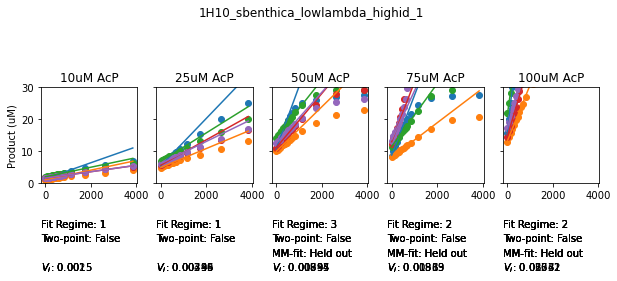

In [241]:
concs = sorted(list(set(sq_merged['substrate_conc_uM'])))

# sample a random mutants and subset the progress curve dictionary
check = np.random.choice(list(set(sq_merged['MutantID'])), 1)[0] # id
my_df = sq_merged[sq_merged['MutantID'] == check]


def plot_progress_curve(df, conc, ax, kwargs_for_scatter, kwargs_for_line, fit_descriptors=False, exclude_concs=exclude_concs):
    """
    Inputs:
        - concs: current substrate concentrations
        - df: current chamber df
        - ax: position of plot
        - fit_descriptors: boolean to add descriptors for two-point fit, mm fit exclusion, and initial rate fit regime
    """

    # create a df of substrate concentrations
    conc_df = df[df['substrate_conc_uM'] == conc]


    for index, row in conc_df.iterrows():

        times, product_concs = np.array(row['time_s']), row['kinetic_product_concentration_uM']
        vi = row['initial_rate']
        intercept = row['initial_rate_intercept']
        regime = row['rate_fit_regime']
        two_point_fit = row['two_point_fit']

        # plot data for the current chamber
        ax.scatter(times, product_concs, **kwargs_for_scatter) # plot progress curve
        ax.plot(times, (times*vi) + intercept, **kwargs_for_line) # plot initial rate line
        # ax.set_xticklabels([]) # remove tick labels

        if fit_descriptors==True:

            # add regime text
            ax.text(0, -0.45, "Fit Regime: " + str(regime), transform=ax.transAxes) # Here, transAxes applies a transform to the axes to ensure that spacing isn't off between plots

            # add two-point fit
            if two_point_fit == True:
                ax.text(0, -0.6, "Two-point: " + str(two_point_fit), color='red', transform=ax.transAxes) # Here, transAxes applies a transform to the axes to ensure that spacing isn't off between plots
            else:
                ax.text(0, -0.6, "Two-point: " + str(two_point_fit), transform=ax.transAxes) # Here, transAxes applies a transform to the axes to ensure that spacing isn't off between plots
            
            # add MM exclusion text
            if conc in exclude_concs:
                ax.text(0, -0.75, "MM-fit: Held out", transform=ax.transAxes) # Here, transAxes applies a transform to the axes to ensure that spacing isn't off between plots

            # add initial rate text
            ax.text(0, -0.9, "$V_i$: " + str(round(vi, 5)), transform=ax.transAxes) # Here, transAxes applies a transform to the axes to ensure that spacing isn't off between plots

        ax.set_title(str(conc) + 'uM AcP')
        ax.set_box_aspect(1)
        # ax.set_ylim([0, max(product_concs)*1.2])
        ax.set_ylim([0, 30])


# set figure settings
fig, axs = plt.subplots(ncols=5, figsize=(10,3), sharey=True)

# test plotting function
for conc, ax in dict(zip(concs, axs)).items():
    plot_progress_curve(my_df, conc, ax, kwargs_for_scatter={}, kwargs_for_line={}, fit_descriptors=True)

axs[0].set_ylabel('Product (uM)')
fig.suptitle(check, y=1.1)
plt.show()

Define heatmap function

In [242]:
def heatmap(data, ax=None, norm=None,
            cbar_kw=None, cbarlabel="", display_cbar=True, **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    # if ax is None:
    #     ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, aspect='equal', **kwargs)

    # Create colorbar
    if display_cbar == True:
        norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
        cbar = ax.figure.colorbar(im, ax=ax, norm=norm, **cbar_kw)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    else:
        cbar = None

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

Generate summary PDFs

/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_95708/2473226210.py:37: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = ax.figure.colorbar(im, ax=ax, norm=norm, **cbar_kw)


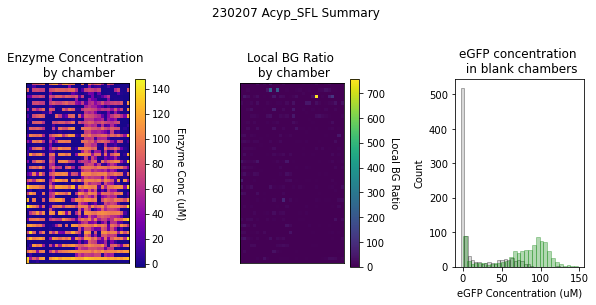

Processing (2, 8):   4%|▎         | 64/1792 [01:23<37:23,  1.30s/it]   


KeyboardInterrupt: 

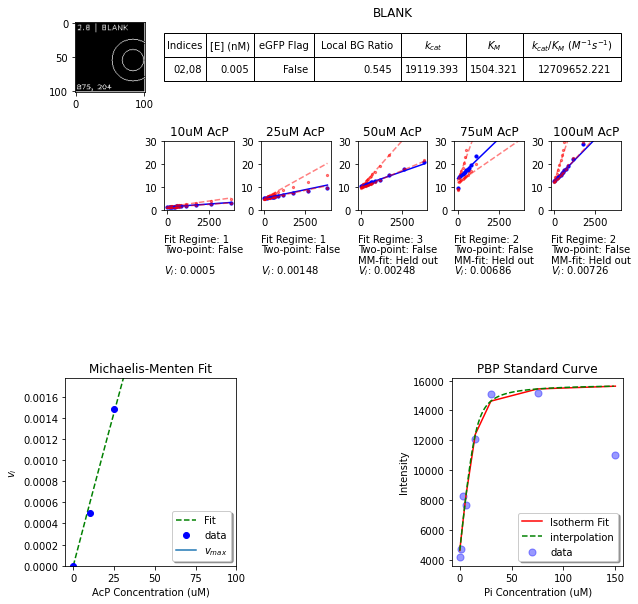

In [243]:
# Plot Chip Summary

# create export directory
newpath = export_path_root + '/PDF/pages/'

if not os.path.exists(newpath):
    os.makedirs(newpath)

## defining figure ============================================================
# initialize figure
fig = plt.figure(figsize=(10, 10)) # size of print area of A4 page is 7 by 9.5

# increase the spacing between the subplots
fig.subplots_adjust(wspace=4, hspace=0.7)
fig.suptitle(' '.join([experimental_day, experiment_name, 'Summary']))

## defining subplots ============================================================
ax_conc_heatmap = plt.subplot2grid((5, 6), (0, 0), rowspan=2, colspan=2) # enzyme concentration heatmap
ax_kinetic_heatmap = plt.subplot2grid((5, 6), (0, 2), rowspan=2, colspan=2) # enzyme concentration heatmap
ax_egfp_hist = plt.subplot2grid((5, 6), (0, 4), rowspan=2, colspan=2) # enzyme concentration heatmap


## Heatmap plotting ============================================================
# fill NaN
grid = squeeze_mm.fillna(0)

# plot enz conc
grid_EC = grid.pivot('x', 'y', 'EnzymeConc').T
grid_EC = grid_EC[grid_EC.columns[::-1]] # flip horizontally
grid_EC = np.array(grid_EC)
display_cbar=True # only display cbar on last grid
norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
im, cbar = heatmap(grid_EC,
                    cmap="plasma", 
                    cbarlabel="Enzyme Conc (uM)", 
                    display_cbar=display_cbar,
                    ax=ax_conc_heatmap,
                    norm=norm
                    )
ax_conc_heatmap.set_xticks([])
ax_conc_heatmap.set_yticks([])
ax_conc_heatmap.set_title('Enzyme Concentration \n by chamber')

# plot enz LBG
grid_kinetic = grid.pivot('x', 'y', 'local_bg_ratio').T
grid_kinetic = grid_kinetic[grid_kinetic.columns[::-1]] # flip horizontally
grid_kinetic = np.array(grid_kinetic)
display_cbar = True # only display cbar on last grid
norm = matplotlib.colors.Normalize(vmin=0, vmax=10)
im, cbar = heatmap(grid_kinetic,
                    cmap="viridis", 
                    cbarlabel="Local BG Ratio", 
                    display_cbar=display_cbar,
                    norm=norm,
                    ax=ax_kinetic_heatmap,
                    )
ax_kinetic_heatmap.set_xticks([])
ax_kinetic_heatmap.set_yticks([])
ax_kinetic_heatmap.set_title('Local BG Ratio \n by chamber')


## Histogram plotting ============================================================

# remove blank chambers
all_blanks = sq_merged[sq_merged['MutantID'] == 'BLANK'][[ "Indices", 'MutantID', 'EnzymeConc']].drop_duplicates(subset=['Indices'], keep='first')
all_library = sq_merged[sq_merged['MutantID'] != 'BLANK'][[ "Indices", 'MutantID', 'EnzymeConc']].drop_duplicates(subset=['Indices'], keep='first')

# plot histograms
n, bins, patches = plt.hist(all_blanks['EnzymeConc'], stacked=True, bins=30, facecolor='grey', alpha=0.3, edgecolor='black')
n, bins, patches = plt.hist(all_library['EnzymeConc'], stacked=True, bins=30, facecolor='green', alpha=0.3, edgecolor='green')

# set plot 
ax_egfp_hist.set_xlabel('eGFP Concentration (uM)')
ax_egfp_hist.set_ylabel('Count')
ax_egfp_hist.set_title('eGFP concentration \n in blank chambers')

plt.savefig(newpath + '00_Chip_Summary.pdf')
plt.show()



# initialize tqdm
with tqdm(total = device_columns * device_rows) as pbar:

    # Plot Chamber-wise Summaries
    for x in range(1, 33):
        for y in range(1, 57, 1):
            
            ## initialize data df ============================================================
            export_kinetic_df = sq_merged[sq_merged['Indices'] == f"{x:02d}" + ',' + f"{y:02d}"]
            export_standards_df = squeeze_standards[squeeze_standards['Indices'] == f"{x:02d}" + ',' + f"{y:02d}"]
            export_mm_df = squeeze_mm[squeeze_mm['Indices'] == f"{x:02d}" + ',' + f"{y:02d}"]
            
            ## defining figure ============================================================
            # initialize figure
            fig = plt.figure(figsize=(10, 10)) # size of print area of A4 page is 7 by 9.5

            # increase the spacing between the subplots
            fig.subplots_adjust(wspace=0.3, hspace=0.7)

            ## defining subplots ============================================================
            ax_image = plt.subplot2grid((5, 5), (0, 0), colspan=1) # chamber image
            ax_first_progress_curve = plt.subplot2grid((5, 6), (1, 1), colspan=1) # progress curves
            ax_second_progress_curve = plt.subplot2grid((5, 6), (1, 2), colspan=1, sharey=ax_first_progress_curve) # progress curves
            ax_third_progress_curve = plt.subplot2grid((5, 6), (1, 3), colspan=1, sharey=ax_first_progress_curve) # progress curves
            ax_fourth_progress_curve = plt.subplot2grid((5, 6), (1, 4), colspan=1, sharey=ax_first_progress_curve) # progress curves
            ax_fifth_progress_curve = plt.subplot2grid((5, 6), (1, 5), colspan=1, sharey=ax_first_progress_curve) # progress curves
            ax_table = plt.subplot2grid((5, 6), (0, 1), colspan=5) # table
            ax_mm_curve = plt.subplot2grid((5, 6), (3, 0), rowspan=2, colspan=2) # chamber image
            ax_pbp_std_curve = plt.subplot2grid((5, 6), (3, 4), rowspan=2, colspan=2) # chamber image


            ## image plotting ============================================================
            img_idx = (x, y)
            ax_image.imshow(button_stamps[img_idx], cmap='gray', vmin=0, vmax=np.max(button_stamps[img_idx]))


            ## PBP std curve fit  ============================================================
            xdata, ydata = export_standards_df.standard_concentration_uM.values[0], export_standards_df.standard_median_intensities.values[0]
            chamber_popt = export_standards_df.standard_popt.values[0]

            # define the interpolation
            interp_xdata = np.linspace(-np.min(xdata), np.max(xdata), num=100, endpoint=False)

            # plot
            ax_pbp_std_curve.plot(xdata, v_isotherm(xdata, *chamber_popt), 'r-', label='Isotherm Fit')
            ax_pbp_std_curve.plot(interp_xdata, v_isotherm(interp_xdata, *chamber_popt), color='g', linestyle='dashed', label='interpolation')
            ax_pbp_std_curve.scatter(xdata, ydata, color='b', s=50, alpha=0.4, label='data')
            ax_pbp_std_curve.set_ylabel('Intensity')
            ax_pbp_std_curve.set_xlabel('Pi Concentration (uM)')
            ax_pbp_std_curve.legend(loc='lower right', shadow=True)
            ax_pbp_std_curve.set_title('PBP Standard Curve')


            ## Michaelis-Menten curve plotting ============================================================
            xdata = export_mm_df.iloc[0].substrate_concs
            ydata = export_mm_df.iloc[0].initial_rates
            MutantID = export_mm_df.iloc[0].MutantID
            Indices = export_mm_df.iloc[0].Indices
            KM_fit = export_mm_df.iloc[0].KM_fit
            vmax_fit = export_mm_df.iloc[0].vmax_fit

            # plot
            t = np.arange(0, 100, 0.2)
            fit_ydata = vfunc(t, *[KM_fit, vmax_fit])
            ax_mm_curve.plot(t, fit_ydata, 'g--', label='Fit') 
            ax_mm_curve.plot(xdata, ydata, 'bo', label='data')
            ax_mm_curve.axhline(vmax_fit, label='$v_{max}$')
            # ax_mm_curve.axvline(KM_fit, ymin=0, ymax=(vmax_fit/.2))
            ax_mm_curve.set_ylabel('$v_i$')
            ax_mm_curve.set_xlabel('AcP Concentration (uM)')
            ax_mm_curve.set_ylim([0, max(ydata)*1.2])
            ax_mm_curve.set_xlim([-max(set(squeeze_kinetics.substrate_conc_uM))/20, max(set(squeeze_kinetics.substrate_conc_uM))])
            ax_mm_curve.legend(loc='lower right', fancybox=True, shadow=True)
            ax_mm_curve.set_title('Michaelis-Menten Fit')


            ## progress curve plotting ============================================================
            concs = set(export_kinetic_df['substrate_conc_uM'])
            
            # find local background indices and store data in new df
            local_background_indices = get_local_bg_indices(x=x, y=y) # stores indices of local background chambers in a list
            local_background_df = pd.DataFrame([])
            for i in local_background_indices:
                data = sq_merged[sq_merged['Indices'] == f"{i[0]:02d}" + ',' + f"{i[1]:02d}"]
                local_background_df = local_background_df.append(data)

            # plot curves
            plot_progress_curve(export_kinetic_df, 10, ax_first_progress_curve, fit_descriptors=True, kwargs_for_scatter={"s": 10, "c": 'blue'}, kwargs_for_line={"c": 'blue'})
            plot_progress_curve(local_background_df, 10, ax_first_progress_curve, kwargs_for_scatter={"s": 5, "c": 'red', 'alpha': 0.5}, kwargs_for_line={"c": 'red', 'alpha': 0.5, 'linestyle': 'dashed'})

            plot_progress_curve(export_kinetic_df, 25, ax_second_progress_curve, fit_descriptors=True, kwargs_for_scatter={"s": 10, "c": 'blue'}, kwargs_for_line={"c": 'blue'})
            plot_progress_curve(local_background_df, 25, ax_second_progress_curve, kwargs_for_scatter={"s": 5, "c": 'red', 'alpha': 0.5}, kwargs_for_line={"c": 'red', 'alpha': 0.5, 'linestyle': 'dashed'})

            plot_progress_curve(export_kinetic_df, 50, ax_third_progress_curve, fit_descriptors=True, kwargs_for_scatter={"s": 10, "c": 'blue'}, kwargs_for_line={"c": 'blue'})
            plot_progress_curve(local_background_df, 50, ax_third_progress_curve, kwargs_for_scatter={"s": 5, "c": 'red', 'alpha': 0.5}, kwargs_for_line={"c": 'red', 'alpha': 0.5, 'linestyle': 'dashed'})

            plot_progress_curve(export_kinetic_df, 75, ax_fourth_progress_curve, fit_descriptors=True, kwargs_for_scatter={"s": 10, "c": 'blue'}, kwargs_for_line={"c": 'blue'})
            plot_progress_curve(local_background_df, 75, ax_fourth_progress_curve, kwargs_for_scatter={"s": 5, "c": 'red', 'alpha': 0.5}, kwargs_for_line={"c": 'red', 'alpha': 0.5, 'linestyle': 'dashed'})
            
            plot_progress_curve(export_kinetic_df, 100, ax_fifth_progress_curve, fit_descriptors=True, kwargs_for_scatter={"s": 10, "c": 'blue'}, kwargs_for_line={"c": 'blue'})
            plot_progress_curve(local_background_df, 100, ax_fifth_progress_curve, kwargs_for_scatter={"s": 5, "c": 'red', 'alpha': 0.5}, kwargs_for_line={"c": 'red', 'alpha': 0.5, 'linestyle': 'dashed'})


            ## table plotting ============================================================
            table_df = export_mm_df[['Indices', 'EnzymeConc', 'egfp_manual_flag', 'local_bg_ratio', 'kcat_fit', 'KM_fit', 'kcat_over_KM_fit']]
            table_df.apply(pd.to_numeric, errors='ignore', downcast='float')
            table_df = table_df.round(decimals=3)

            table = ax_table.table(cellText=table_df.values, loc='center', colLabels=['Indices', '[E] (nM)', 'eGFP Flag', 'Local BG Ratio', '$k_{cat}$', '$K_M$', '$k_{cat}/K_M$ ($M^{-1} s^{-1}$)'])
            table.auto_set_font_size(True)
            table.scale(0.3, 2)
            table.auto_set_column_width(col=list(range(len(table_df.columns))))
            ax_table.set_title(export_kinetic_df.iloc[0].MutantID)
            ax_table.set_axis_off()
            ax_table.set_frame_on(False)

            # update progress bar
            pbar.update(1)
            pbar.set_description("Processing %s" % str((x, y)))

            plt.savefig(newpath + str(Indices) + '.pdf')
            plt.close('all')

    pbar.set_description("Export complete")

#### Merge PDFs

In [ ]:
from os import listdir
from os.path import isfile, join
import PyPDF2

mypath = export_path_root + '/PDF/'

# store all pdf files
all_files = sorted([mypath + 'pages/' + f for f in listdir(mypath + 'pages/') if isfile(join(mypath + 'pages/', f))])
all_files = [f for f in all_files if f[-4:] == '.pdf']

# initialize merger
merger = PyPDF2.PdfFileMerger()

# merge pdfs
for pdf in all_files:
    merger.append(pdf)

# write merged file
merger.write(mypath + "merged.pdf")
merger.close()


# Export Data

In [244]:
# define export df
export_df = pd.merge(squeeze_mm, sq_merged, on=list(np.intersect1d(sq_merged.columns, squeeze_mm.columns)))

# add remaining data
export_df['GlobalExperimentIndex'] = '_'.join([experimental_day, setup, device, substrate])
export_df['Experiment'] = experiment_name

In [245]:
export_df.to_csv(export_path_root + '/' + experimental_day + '_' + substrate + '_workup.csv')

# Added: SFL Analysis

Enzyme Concentration

In [ ]:
# fill NaN
grid = squeeze_mm.fillna(0)

# plot enz conc
grid_EC = grid.pivot('x', 'y', 'EnzymeConc').T
grid_EC = grid_EC[grid_EC.columns[::-1]] # flip horizontally
grid_EC = np.array(grid_EC)
display_cbar = True
im, cbar = heatmap(grid_EC,
                    cmap="plasma", 
                    cbarlabel="Enzyme Conc (uM)", 
                    display_cbar=display_cbar,
                    )
plt.xlabel("Column")
plt.ylabel("Row")

plt.savefig('/Users/micaholivas/Desktop/Stanford/Research/Presentations/Salesforce/4_Outcomes_203_1/SFL_update_013023/enz_conc_heatmap_SFL_1022.png')
# plt.title('Enzyme Concentration \n by chamber')


Additional [E] from additional experiment

/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce Progen Predictions/Small ACYP Library/4_Experiments/221201/Craig workup/221201_S2d2Acyp_SFL.csv.bz2